### Анализ комментариев в тгк по Матанализу

**Описание**:

Здесь расскажите, откуда будете брать данные, что собираетесь анализировать

In [1]:
# ячейка для импортов модулей проекта
# оставьте все импорты здесь
from telethon.sync import TelegramClient
from telethon.tl.types import PeerChannel
from telethon.tl.functions.channels import GetFullChannelRequest
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from collections import Counter
from dotenv import load_dotenv
import os

# Загрузка данных

В данном разделе выполните выгрузку данных из внешних источников и их локальное сохранение. Важно данные были загруженны 30.04

Вы можете вынести всю логику выгрузки в отдельный `.py` скрипт (или набор скриптов), поместив их в директорию `scripts` в корне проекта, но продублируйте весь код здесь тоже, чтобы можно было запустить ноутбук с самого начала

**Устанавливаем соеденение с TG API**

In [2]:
load_dotenv()

api_id = int(os.getenv("API_ID"))
api_hash = os.getenv("API_HASH")

client = TelegramClient('my_session.session', api_id, api_hash)
await client.start()


Server sent a very old message with ID 7503194836153249793, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195008114354177, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195032937094145, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195032937094149, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195071117709313, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195084430765057, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195125567307777, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195142730359809, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195152574752769, ignoring (see FAQ for details)
Server sent a very old message with ID 7503195152574752773, ignoring (see FAQ for details)
Security error while unpacking a received message: Too many messages had to be ignored con

**Скачиваем данные**

In [3]:
entity = await client.get_entity('https://t.me/+kZ9Y3KuqGwU2NmY6')

full_entity = await client(GetFullChannelRequest(entity))

print(full_entity.full_chat.linked_chat_id)


2160414837


In [4]:
channel_username = full_entity.full_chat.linked_chat_id
all_messages = []

# Данные скачиваются медленно спецально, чтобы ТГ API не стопанул, минуты 3-4 скачивается
async for message in client.iter_messages(channel_username, reverse=True):
    all_messages.append({
        'id': message.id,
        'date': message.date,
        'text': message.text,
        'sender_id': message.sender_id
    })


import pandas as pd
data = pd.DataFrame(all_messages)
data.to_csv('messages.csv', index=False)


## Очистка данных и подготовка к анализу

Для моего датафрейма необходимо, избавиться от пустых коменнатариев, почему есть пустые значения, пустые значения это либо стикеры, фото или ГС, так как в группе запрещены ГС и стикеры, значит это фото, скорее всего я все таки не уберу, а заменю пропуски на Photo. Пользователей чей id нам не выдал(то есть пропуск в графе) api заменить пропуск на Unkown. Также sender_id -1002163089538.0 это id самого ТГК, так как в коментариях пост прикрепрен сверху всегда, дальше посчитаю сколько сообщений от этого id, для статистики, чтобы понять число постов, и удалю из датафрейма. Также стоит проеврить тип данных date, для дальнейшей работы.

In [5]:
# Заменить пропуски в text на Photo
data['text'] = data['text'].fillna('Photo')

# Заменить пропуски в sender_id на Unknown
data['sender_id'] = data['sender_id'].fillna('Unknown')

# Посчитать количество сообщений от самого ТГК
post_count = (data['sender_id'] == -1002163089538.0).sum()
print(f"Количество сообщений от ТГК (закрепленных постов): (257){post_count}")

# Удалить строки, где sender_id == -1002163089538.0
data = data[data['sender_id'] != -1002163089538.0]

# Привести 'date' к типу datetime64
data['date'] = pd.to_datetime(data['date'])

print(data.info())
print(data.head())


Количество сообщений от ТГК (закрепленных постов): (257)275
<class 'pandas.core.frame.DataFrame'>
Index: 2965 entries, 0 to 3238
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         2965 non-null   int64              
 1   date       2965 non-null   datetime64[ns, UTC]
 2   text       2965 non-null   object             
 3   sender_id  2965 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 115.8+ KB
None
   id                      date  \
0   1 2024-08-29 19:46:05+00:00   
4   5 2024-09-06 12:29:44+00:00   
6   7 2024-09-06 13:54:46+00:00   
7   8 2024-09-06 13:55:47+00:00   
8   9 2024-09-06 14:08:30+00:00   

                                                text     sender_id  
0                                              Photo       Unknown  
4                                              Photo  6352580519.0  
6  Здравствуйте, когда будет

Первые 5 строк:
    id                      date  \
0   1 2024-08-29 19:46:05+00:00   
4   5 2024-09-06 12:29:44+00:00   
6   7 2024-09-06 13:54:46+00:00   
7   8 2024-09-06 13:55:47+00:00   
8   9 2024-09-06 14:08:30+00:00   

                                                text     sender_id  msg_length  
0                                              Photo       Unknown           5  
4                                              Photo  6352580519.0           5  
6  Здравствуйте, когда будет скинута ссылка на за...  1000461829.0          81  
7                                              Photo  1121610363.0           5  
8  Ссылка на zoom прикреплена на сайте my.itmo.ru...   831284577.0         134   

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 2965 entries, 0 to 3238
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   id          2965 non-null   int64              


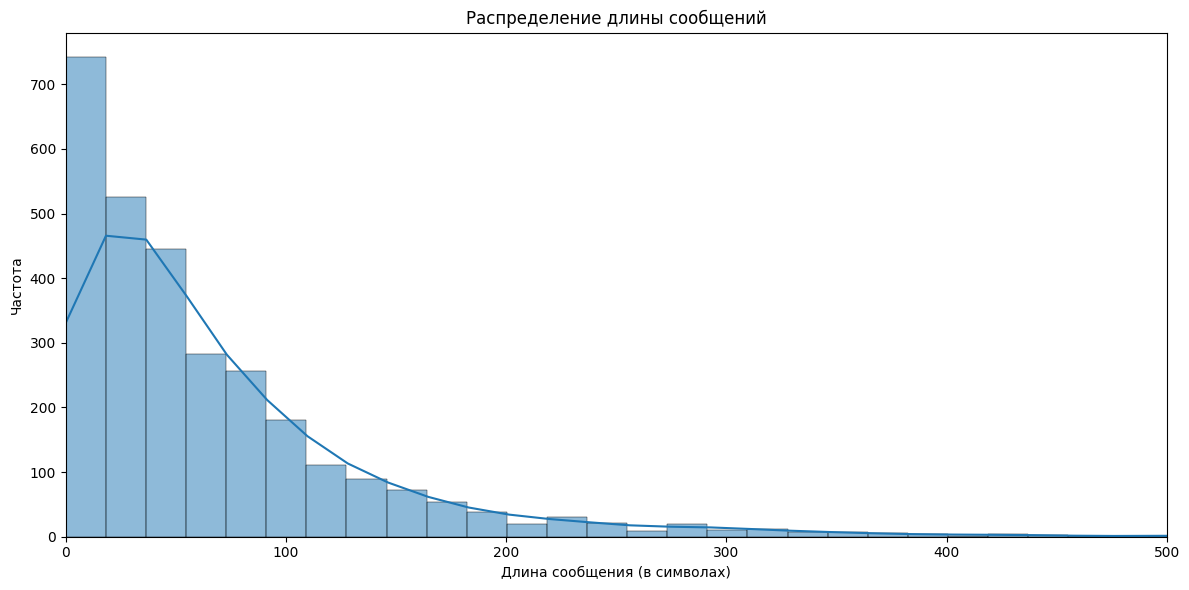

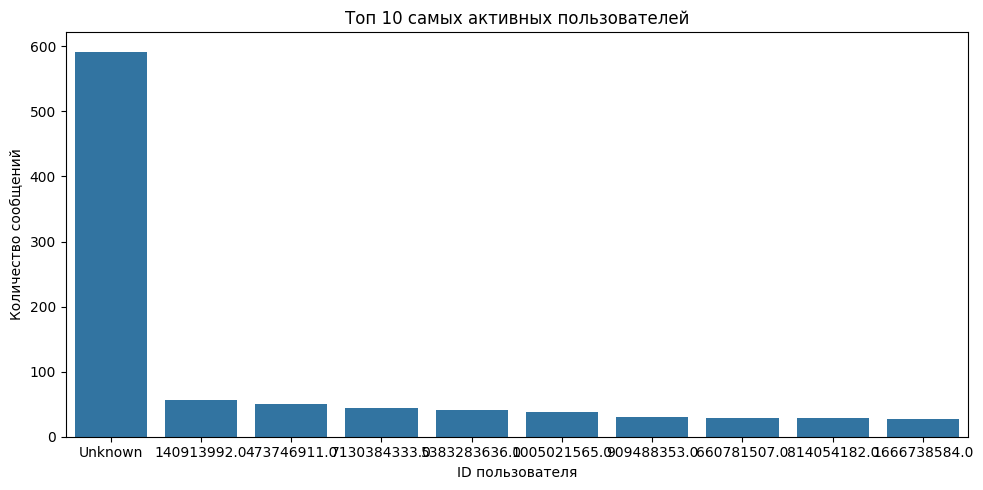

In [31]:
print("Первые 5 строк:\n", data.head(), "\n")


print("Информация о DataFrame:")
print(data.info(), "\n")

# Статистика по числовым колонкам, 
print("Описательная статистика:\n", data.describe(include=[float, int]), "\n")

# Уникальные значения по каждому столбцу
print("Количество уникальных значений:")
for col in data.columns:
    print(f"{col}: {data[col].nunique()}")

# Пропущенные значения
print("\nКоличество пропущенных значений:")
print(data.isnull().sum(), "\n")


# Распределение длин сообщений
data["text"] = data["text"].fillna("Photo")
data["msg_length"] = data["text"].astype(str).apply(len)
plt.figure(figsize=(12, 6 ))
sns.histplot(data["msg_length"], bins=200, kde=True)
plt.xlim(0, 500) 
plt.title("Распределение длины сообщений")
plt.xlabel("Длина сообщения (в символах)")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

# Активные пользователи
plt.figure(figsize=(10, 5))
top_authors = data["sender_id"].value_counts().head(10)
sns.barplot(x=top_authors.index.astype(str), y=top_authors.values)
plt.title("Топ 10 самых активных пользователей")
plt.xlabel("ID пользователя")
plt.ylabel("Количество сообщений")
plt.tight_layout()
plt.show()

Все данные в удобном формате для дальнейшего анализа. Есть один выброс в значения msg_length(длинна собщений в символах) 3642.000000
ниже выведу это сообщение. В данных нету пропусков. Всего sender_id: 618, то есть 618 уникальных пользователей. Большенство пользователей пишут сообщение длинной меньше 100 символов. Из частоты написания unkown раньше NaN можно предположить, что это админ пишет от лица группы, потому что именно в такой ситуации id не передается, проверю это ниже, также ввыеду сомое большое сообщение

In [37]:
print("Самое длинное сообщение:\n", data.loc[data['msg_length'].idxmax(),'text'])

unknown_comments = data[data['sender_id'] == 'Unknown']
print(unknown_comments[['date', 'text']])


Самое длинное сообщение:
 Господа, я люблю матанализ. Господа, я люблю матанализ. Господа, я люблю матанализ!
Люблю строить числовые прямые, люблю выставлять масшаб, люблю наносить на карту точки, через которые я буду простраивать график. Когда из-за изначально кривого масштаба приходится перестраивать весь чертёж, моё сердце поёт! Люблю, когда на парах десяток человек сходится в схватке с учебными примерами. Ничто не приносит мне такое же удовольствие, как поиск площади под кривой или вычисление объёмов с помощью определённых интегралов. Представьте только: бесконечные суммы, пределы, производные функций, занесение в дифференциал... До чего же приятное зрелище, когда испуганный первак тыкается в таблицу интегралов в надежде что-либо заучить. Раз за разом, в глубине моего сердца вновь разгорается любовь к интегрированию, особенно во время допсы по этому предмету, когда стройные ряды людишек покорно берут варианты теорминов друг за другом, но чьи мечты о счастливой жизни будут разрушены

Самое длинное сообщение это не выброс, а мольба о помощи. 
Unkown - это админ, это можно понять по его сообщениям, которые всегда являются ответом и пишутся от лица группы.

## Анализ и визуализация

В исследовании использованы три типа визуализации: облако слов, столбчатая диаграмма и тепловая карта. Такой выбор обоснован тем, что каждый из методов дополняет остальные и в совокупности позволяет раскрыть разные стороны пользовательской активности. Облако слов и диаграмма визуализируют частотность слов, при этом облако — наглядное и привлекательное, а диаграмма — точное и числовое. Тепловая карта показывает распределение активности по времени, позволяя выявить пиковые часы и дни. В итоге визуализации охватывают как содержательную, так и временную структуру комментариев. Для будущего понимания всего 3144 коментариев и 257 постов.

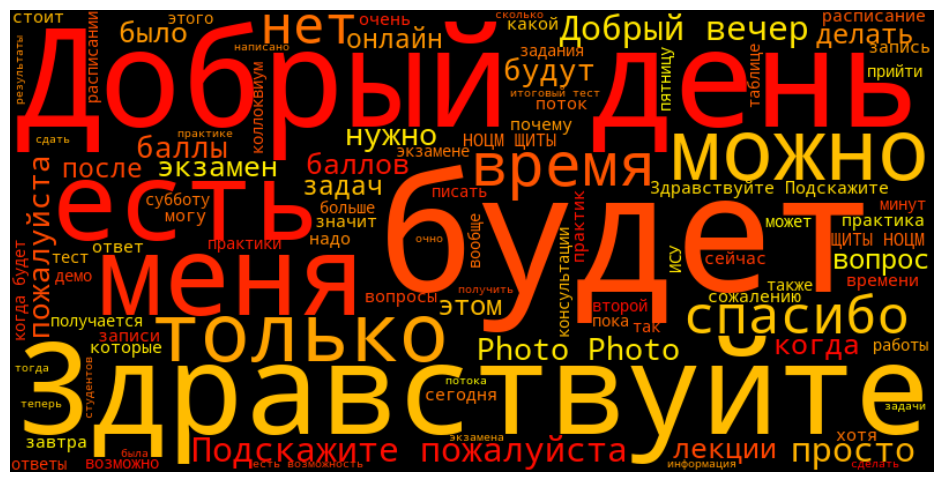

In [13]:
stopwords_custom = {
    'в', 'на', 'с', 'из', 'у', 'по', 'к', 'о', 'об', 'за', 'до', 'от', 'для', 'при', 'через', 'над', 'под', 'без',
    'и', 'а', 'но', 'или', 'что', 'как', 'если', 'то', 'потому', 'либо', 'тоже', 'чтобы', 'да', 'же',
    'не', 'ни', 'ли', 'бы', 'же', 'пусть', 'даже', 'ведь', 'разве', 'уж', 'точно', 'именно', 'почти', 'я'
    }

all_text = ' '.join(data['text'].astype(str))

filtered_words = [word for word in all_text.split() if len(word) > 3 and word.lower() not in stopwords_custom]
filtered_text = ' '.join(filtered_words)

# Создаем облако слов с удалением стоп-слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    max_words=100,
    colormap = 'autumn',
    stopwords=stopwords_custom
).generate(filtered_text)


plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Облако слов показывает, что комментарии в ТКГ в основном состоят из вопросов и просьб, что ожидайма от учебного ТГК. Часто встречаются вежливые слова, такие как: "Добрый день", "Здравствуйте", "Спасибо", "Пожалуйста", что указывает на вежливое общение между студентами и преподавателями. Также очевидны слова связанные с оцениванием и организацией курса (экзамен, баллы, коллоквиум, лекции, силлабус), это может выделять какие то основные категории в которых у студентов возникает проблемы. Фразы  "НОЦМ ЩИТЫ" или "ЩИТЫ НОЦМ" локальный мем в ТГК. Облако слов даёт общее представление о темах и стиле общения, но ограничено в аналитике не учитывает контекст и не различает формы слов, по этому выводить какие то точные гепотезы, затруднительно.

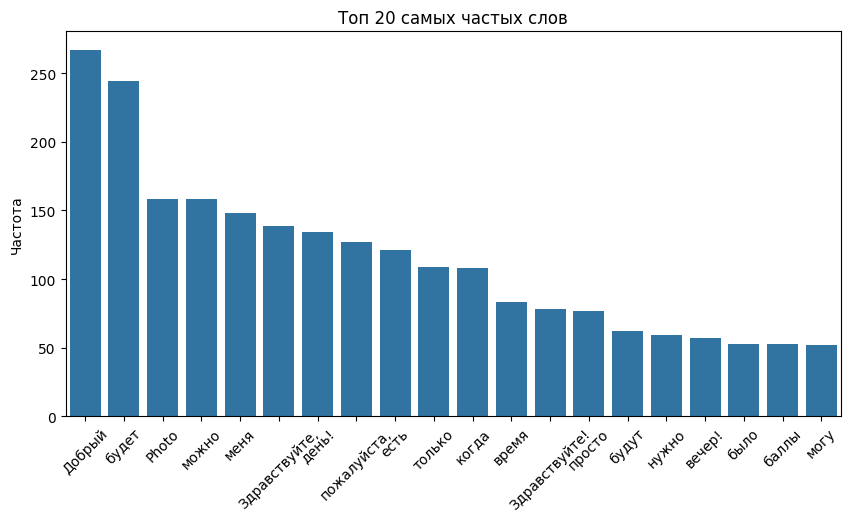

In [14]:
# Считаем частоту слов
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

# Строим график
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts))
plt.title('Топ 20 самых частых слов')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()


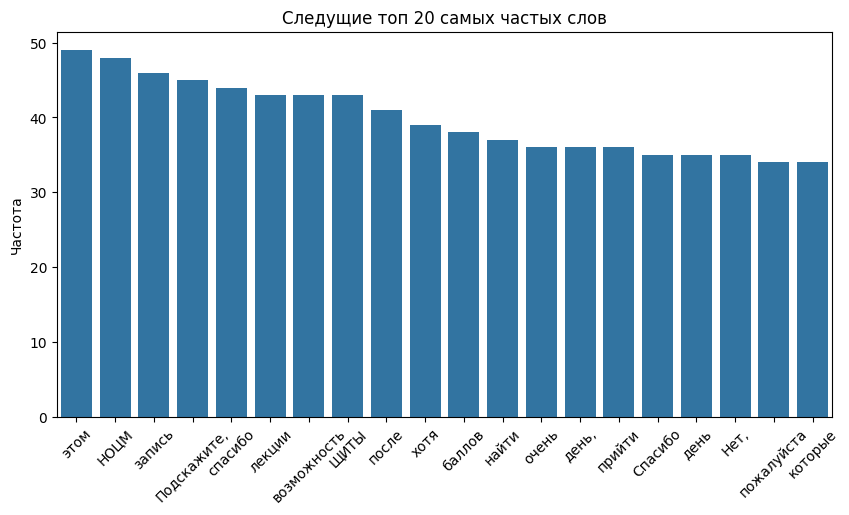

In [120]:
common_words1 = word_counts.most_common()[20:40]
words1, counts1 = zip(*common_words1)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(words1), y=list(counts1))
plt.title('Следущие топ 20 самых частых слов')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Для более полного анализа я рассмотрел топ-40 наиболее частых слов, разделив их на две диаграммы для удобства восприятия. Слово «день» встречается значительно чаще, чем «вечер» или «утро», что позволяет выдвенуть гепотизу, что студенты активнее пишут днём.  На 3 месте (чуть больше 150) по использованию Photo, говорит о том, что студенты часто делятся ошибками в формате скриншота, это может говорить о ошибках в Геолине (системе для написания работ), но также не стоит исключать, что студенты могут использовать фото как ссылку, для подтверждение своих слов. Упоминания «баллов» (около 90 раз) могут отражать трудности в системе оценивания или задержки в публикации результатов. Интересно то, что слово "будет" употребляется около 240 раз, это топ 2 слова, если топ 1 слово в полне оправдно тем, что часто используется при общении, то слово "будет", может говорить о том, что сутеднтов "слишком занимает то, что будет. Мудрецы говорят: прошедшее забыто, грядущее закрыто, настоящее даровано. Поэтому его и зовут настоящим!" (Угвэй)

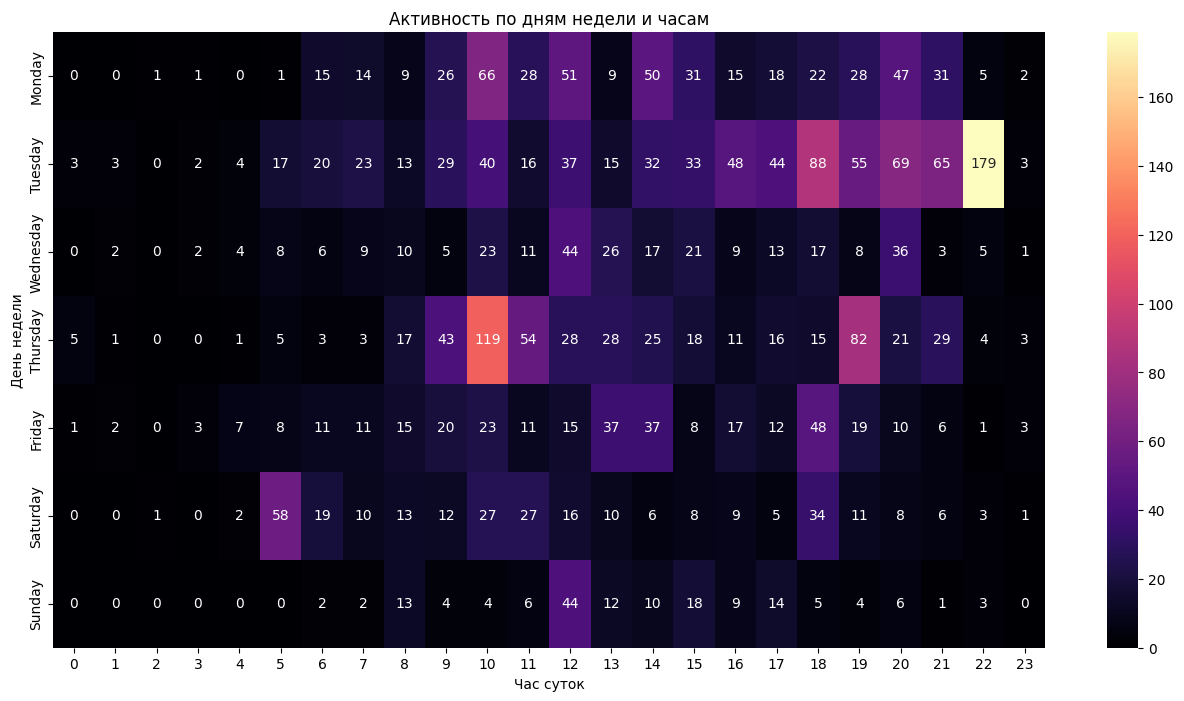

In [129]:
# Выделяем день недели и час
data['weekday'] = data['date'].dt.day_name()  
data['hour'] = data['date'].dt.hour  


pivot_table = data.pivot_table(index='weekday', columns='hour', values='text', aggfunc='count', fill_value=0)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

# Строим тепловую карту 
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_table, cmap='magma', annot=True, fmt='d')
plt.title('Активность по дням недели и часам')
plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.show()


In [34]:
print(data_post.columns)


Index(['post_id', 'comment_count', 'date', 'weekday', 'hour'], dtype='object')


Тепловая карта показывает распределение комментариев по времени. Основная активность приходится на вечерние часы, что логично для учебного контекста — студенты, вероятно, пишут после пар, особенно в период подготовки к экзаменам и сдачи работ. Это опровергает ранее выдвинутую гипотезу о том, что сообщения чаще пишутся днём. Отдельные всплески комментариев совпадают с публикацией важных постов: например, во вторник в 22:00 был опубликован пост об изменении порядка проведения контрольной, что вызвало активное обсуждение. Это позволяет выдвинуть новую гипотезу: время комментариев напрямую связано с моментом публикации постов.

## Выводы 

Анализ комментариев учебного ТГК показал ряд интересных закономерностей как в содержании сообщений, так и во временной активности студентов. Были построены визуализации: облако слов, гистограммы самых частых слов (топ-20 и топ-40), а также тепловая карта активности по дням недели и часам. Эти визуализации позволили не просто представить данные, но и сделать конкретные выводы.

**Во-первых**, стиль общения студентов оказался вежливым — среди самых частых слов встречаются «здравствуйте», «добрый», «спасибо», «пожалуйста». Это говорит о культурной манере общения даже в стрессовых учебных ситуациях.

**Во-вторых**, по частоте тем можно выделить три основные группы проблем, с которыми обращаются студенты:

- Проблемы с Геолином (система электронного обучения);

- Проблемы с системой оценивания (часто упоминаются баллы, ППА, коллоквиумы);

- Недостаток информации о курсе (вопросы по расписанию, щитам, лекциям и т.д.).

Также анализ активности показал, что студенты чаще всего пишут комментарии вечером, особенно после 18:00, что совпадает с завершением учебного дня. Наиболее активные дни — вторник и четверг. В это время чаще всего публикуются посты преподавателей, что вызывает всплеск комментариев. Это позволяет выдвинуть гипотезу о том, что активность студентов напрямую зависит от времени публикации важных постов.

Дополнительно была построена тепловая карта времени публикации самих постов. Она показала, что посты чаще публикуются в рабочие дни, особенно ближе к вечеру, что логично с учётом графика преподавателей. Это подтверждает связь между временем публикации постов и последующей активностью студентов в комментариях.

В целом, работа позволила не просто визуализировать текстовые данные, а выявить реальные паттерны поведения и основные болевые точки студентов. Это может быть полезно для улучшения коммуникации и снижения числа повторяющихся вопросов.

## Обсуждение

В рамках исследования я хотел проанализировать комментарии студентов в учебном ТГК, чтобы понять, с какими проблемами они чаще всего сталкиваются, как общаются и когда проявляют наибольшую активность. Мне удалось собрать сообщения, выделить ключевые слова, построить визуализации и на основе этого выявить наиболее волнующие темы, такие как проблемы с обучающей платформой Геолин, системой оценивания и нехваткой информации по курсу. Также удалось установить, что студенты чаще пишут вечером, особенно после публикации крупных постов.

Не удалось 
– собрать не только комментарии, но и посты для анализа связи между содержанием поста и активностью в комментариях,
– автоматически выделять тональность сообщений,
– анализировать структуру диалогов (ответы на ответы),
– построить полноценный пайплайн с автоматическим обновлением данных.

Основные причины этого:
– ограничений API Telegram (например, Telegram не всегда отдаёт всю структуру комментариев),
– отсутствия точных временных меток публикации постов и комментариев,
– нехватки времени на настройку и реализацию полноценной обработки текста и моделей анализа тональности.

Исследование можно было бы улучшить за счёт:

- более глубокой обработки текста (например, объединения форм слов, удаления лишних стоп-слов, учёта контекста),

- анализа тональности сообщений, чтобы точнее понять эмоциональный фон,

- добавления данных за более длительный период для выявления трендов.

Результаты могут быть полезны как преподавателям и кураторам курса — для понимания, где чаще всего возникают проблемы у студентов, так и самим студентам — например, при навигации по наиболее часто обсуждаемым вопросам. В перспективе логику анализа можно перенести и на другие студенческие чаты или внутренние корпоративные форумы, чтобы выявлять болевые точки в коммуникации и оперативно на них реагировать.